<a href="https://colab.research.google.com/github/saurabh423/-Support-Vector-Machine/blob/main/Support_Vector_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <u><b> Objective </b></u>
## <b> You are given a data of US Airline tweets and their sentiment. The task is to do sentiment analysis about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service"). </b>

<br>
<br>

## <b>Things to do :</b>
* ### Read the tweets.csv data, clean and tokenize the tweets using nltk library.
* ### Count vectorize the tweets so that you end up with a sparse matrix (which will be your $X$). 
* ### You are supposed to build a SVM classifier (a binary classification in fact). Since the data contains three levels of sentiment(positive, negative and neutral), you should remove the sentences which are neutral. Once you do that you will have two classes only (positive and negative). You can set the label of positive tweets to 1 and negative tweets to 0.
* ### Once you have built the SVM classifier, evaluate this model across various metrics. Also plot the ROC curve and Precision-Recall curve. Report the areas under these two curves along with other metrics.
* ### Perform GridSearch cross validation for various values of $C$ and $gamma$. These will be the hyperparameters which you would play around with.
* ### Explain your observations and the underlying reasons for these.
* ### Try checking if <code>tfidfvectorizer</code> helps you gain lift in model's performance.





In [3]:
#Load the necessary python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading the tweets.csv data

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Almabetter/Module 4: Machine Learning/Week 3/Day 3: Support Vector Machines/dat/Tweets.csv")

In [6]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
pd.set_option('display.max_colwidth',-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [8]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


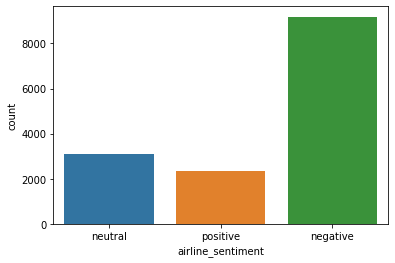

In [9]:
sns.countplot(x=df['airline_sentiment'])

Most tweets are negative according to the airline.

In [10]:
df['length']=df['text'].apply(len)


In [11]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,length
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),35
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),72
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),71
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),126
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),55


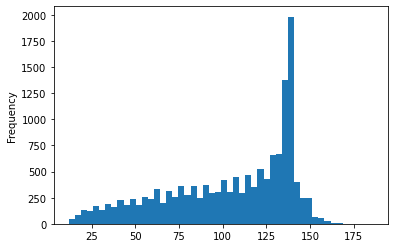

In [12]:
df['length'].plot(bins=50,kind='hist')

In [13]:
df['length'].describe()

count    14640.000000
mean     103.822063  
std      36.277339   
min      12.000000   
25%      77.000000   
50%      114.000000  
75%      136.000000  
max      186.000000  
Name: length, dtype: float64

In [14]:
df[df['length']==186]['text'].iloc[0]

"@USAirways Eyyyy! Cancelled Flightlations, Flight Booking Problemss, reFlight Booking Problemss, but y'all got me on the same flight out tonight (not tomorrow) &amp; the FC upgrade. Thx!"

# Removing the neutral value from sentiment

In [15]:
df = df[df.airline_sentiment != 'neutral'].reset_index()


## Let us write a function which removes punctuation and stopwords from our data

In [16]:
# Import required library
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
import string
from nltk.corpus import stopwords

In [18]:
stopset=stopwords.words('english')

In [19]:
#Function to remove punctuations
def text_process(msg):
    nopunc =[char for char in msg if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

## Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

In [20]:
df['tokenized_text'] = df['text'].apply(text_process)

In [21]:
df.head()

,index,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,length,tokenized_text
0,1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),72,VirginAmerica plus youve added commercials experience tacky
1,3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),126,VirginAmerica really aggressive blast obnoxious entertainment guests faces amp little recourse
2,4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),55,VirginAmerica really big bad thing
3,5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),135,VirginAmerica seriously would pay 30 flight seats didnt playing really bad thing flying VA
4,6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),79,VirginAmerica yes nearly every time fly VX “ear worm” won’t go away


Now considering only thecolumn that we want

In [22]:
tweet=df[['airline_sentiment','tokenized_text','length']]

In [23]:
tweet.head()

,airline_sentiment,tokenized_text,length
0,positive,VirginAmerica plus youve added commercials experience tacky,72
1,negative,VirginAmerica really aggressive blast obnoxious entertainment guests faces amp little recourse,126
2,negative,VirginAmerica really big bad thing,55
3,negative,VirginAmerica seriously would pay 30 flight seats didnt playing really bad thing flying VA,135
4,positive,VirginAmerica yes nearly every time fly VX “ear worm” won’t go away,79


 Setting the label of positive tweets to 1 and negative tweets to 0 in sentiment feature.

In [24]:
tweet.replace({'airline_sentiment':{'positive':1, 'negative':0}}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [25]:
tweet.head()

,airline_sentiment,tokenized_text,length
0,1,VirginAmerica plus youve added commercials experience tacky,72
1,0,VirginAmerica really aggressive blast obnoxious entertainment guests faces amp little recourse,126
2,0,VirginAmerica really big bad thing,55
3,0,VirginAmerica seriously would pay 30 flight seats didnt playing really bad thing flying VA,135
4,1,VirginAmerica yes nearly every time fly VX “ear worm” won’t go away,79


###Linear SVM classifier:

We will build a simple, linear Support-Vector-Machine (SVM) classifier. The classifier will take into account each unique word present in the sentence, as well as all consecutive words.

 To make this representation useful for our SVM classifier we transform each sentence into a vector. The vector is of the same length as our vocabulary, i.e. the list of all words observed in our training data, with each word representing an entry in the vector. If a particular word is present, that entry in the vector is 1, otherwise 0.

**Preparing the data**

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['tokenized_text'])

In [28]:
X = tweet['tokenized_text']
Y = tweet['airline_sentiment']

## <b>Training a model</b>

### Firstly we will do the usual train test split

In [29]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(tweet['tokenized_text'],tweet['airline_sentiment'],test_size=0.4)

In [30]:
x_train.head()

5010    SouthwestAir poisonpill76 im boat 8am flight Jacksonville Get         
9832    AmericanAir says web site u fly directly ORD DUB try book says stopped
4059    SouthwestAir flying Spirit air                                        
7887    USAirways jtrexsocial 5 hours hold Safe say one working               
2420    united WTH honest customers better last change driving home plane left
Name: tokenized_text, dtype: object

In [31]:
y_train.head()

5010    0
9832    0
4059    0
7887    0
2420    0
Name: airline_sentiment, dtype: int64

 ## Now we can use Support Vector Machine to perform this classification task.

In [32]:
train_vectorized = vectorizer.transform(x_train)
test_vectorized = vectorizer.transform(x_test)

In [33]:
train_vectorized

<6924x13843 sparse matrix of type '<class 'numpy.int64'>'
	with 72793 stored elements in Compressed Sparse Row format>

In [34]:
train_array= train_vectorized.toarray()
test_array = test_vectorized.toarray()

In [35]:
#Import svm model
from sklearn import svm

In [36]:
#Create a svm Classifier
clf = svm.SVC()

In [37]:
#Train the model using the training sets
clf.fit(train_vectorized, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [38]:
#Predict the response for test dataset
test_pred = clf.predict(test_vectorized)


In [39]:
#Predict the response for train dataset
train_pred =  clf.predict(train_vectorized)

# **Evaluation of results**

In [40]:
# Evaluation Score for train dataset
clf.score(train_vectorized, y_train)

0.9702484113229347

In [41]:
# Evaluation Score for test dataset
clf.score(test_vectorized, y_test)

0.9042668399393545

# **Evaluating the Model**

In [42]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy on test:",metrics.accuracy_score(y_test, test_pred))
print("Accuracy on train:",metrics.accuracy_score(y_train, train_pred))

Accuracy on test: 0.9042668399393545
Accuracy on train: 0.9702484113229347


In [43]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision for test data:",metrics.precision_score(y_test, test_pred))
print("Precision for train data:",metrics.precision_score(y_train, train_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall for test data:",metrics.recall_score(y_test, test_pred))
print("Recall for train data:",metrics.recall_score(y_train, train_pred))

Precision for test data: 0.9069400630914827
Precision for train data: 0.9823008849557522
Recall for test data: 0.6002087682672234
Recall for train data: 0.8690391459074733


In [44]:
from sklearn.metrics import roc_auc_score, confusion_matrix

In [45]:
# Calculate roc_auc score on train set
roc_auc_score(y_train,train_pred)

0.9325264582590457

In [46]:
# Calculate roc_auc score on test set
roc_auc_score(y_test,test_pred)

0.7920420720264787

In [47]:
# Obtain the confusion matrix on train set
confusion_matrix(y_train,train_pred)

array([[5497,   22],
       [ 184, 1221]])

In [48]:
# Obtain the confusion matrix on test set
confusion_matrix(y_test,test_pred)

array([[3600,   59],
       [ 383,  575]])

# Ploting ROC curve and Precision-Recall curve

For Train DATA

In [49]:
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report

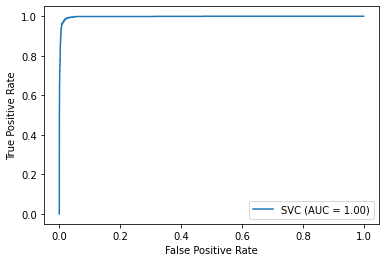

In [50]:
from sklearn import datasets, metrics, model_selection, svm
metrics.plot_roc_curve(clf, train_vectorized, y_train) 
plt.show()

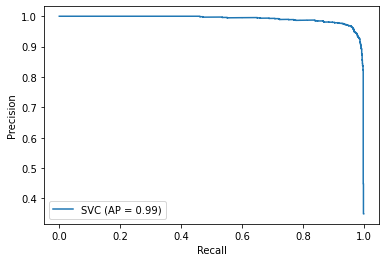

In [51]:
# precision recall curve
metrics.plot_precision_recall_curve(clf, train_vectorized, y_train)

For Test Data

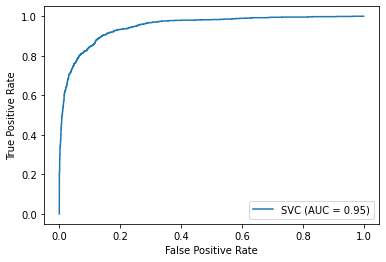

In [52]:
metrics.plot_roc_curve(clf, test_vectorized, y_test)

In [53]:
# Area under ROC curve
roc_auc_score(y_test,test_pred)

0.7920420720264787

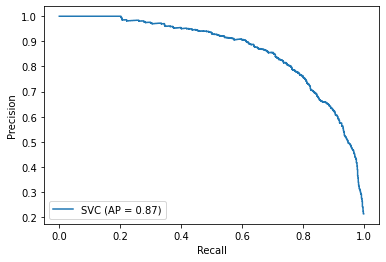

In [54]:
metrics.plot_precision_recall_curve(clf, test_vectorized, y_test)

In [55]:
# Print the classification report for train and test
print(classification_report(y_train,train_pred))
print("\n")
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5519
           1       0.98      0.87      0.92      1405

    accuracy                           0.97      6924
   macro avg       0.97      0.93      0.95      6924
weighted avg       0.97      0.97      0.97      6924



              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3659
           1       0.91      0.60      0.72       958

    accuracy                           0.90      4617
   macro avg       0.91      0.79      0.83      4617
weighted avg       0.90      0.90      0.90      4617



# **Performing GridSearch cross validation for various values of  C  and  gamma**

In [88]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear','poly']} 
grid = GridSearchCV(clf, param_grid,n_jobs=2, cv=5, verbose = 2,scoring='accuracy')

What **fit** does is a bit more involved then usual. First, it runs the same loop with **cross-validation**, to find the best parameter combination. Once it has the best combination, it runs fit again on all data passed to fit (without cross-validation), to built a single new model using the best parameter setting

In [89]:
grid.fit(train_vectorized,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed: 12.5min
[Parallel(n_jobs=2)]: Done 375 out of 375 | elapsed: 12.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=2)

In [90]:
# Best values for C and Gamma are:
grid.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [91]:
g_pred_train=grid.predict(train_vectorized)

In [92]:
g_pred_test=grid.predict(test_vectorized)

In [93]:
# Confusion matrices for train and test 

print(confusion_matrix(y_train,g_pred_train))
print(confusion_matrix(y_test,g_pred_test))

[[5484   35]
 [ 133 1272]]
[[3553  106]
 [ 265  693]]


In [94]:
# Print the classification report for train and test
print(classification_report(y_train,g_pred_train))
print("\n")
print(classification_report(y_test,g_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5519
           1       0.97      0.91      0.94      1405

    accuracy                           0.98      6924
   macro avg       0.97      0.95      0.96      6924
weighted avg       0.98      0.98      0.98      6924



              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3659
           1       0.87      0.72      0.79       958

    accuracy                           0.92      4617
   macro avg       0.90      0.85      0.87      4617
weighted avg       0.92      0.92      0.92      4617



##**Vectorize using TFIDF vectorizer.**

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [66]:
# create the transform
tf_vectorizer = TfidfVectorizer()
# tokenize and encode document
X = tf_vectorizer.fit_transform(df['tokenized_text'])
y = tweet.airline_sentiment

In [67]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.4)

In [68]:
#Create a svm Classifier
clf_tf = svm.SVC()

In [69]:
# Training the model
clf_tf.fit(X_train,Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [70]:
tf_train_pred=clf_tf.predict(X_train)
tf_test_pred=clf_tf.predict(X_test)

In [71]:
tf_train_pred

array([0, 0, 0, ..., 1, 1, 0])

In [72]:
# Confusion matrices for train and test 

print(confusion_matrix(Y_train,tf_train_pred))
print(confusion_matrix(Y_test,tf_test_pred))

[[5504    5]
 [  74 1341]]
[[3631   38]
 [ 413  535]]


In [73]:
# Print the classification report for train and test
print(classification_report(y_train,tf_train_pred))
print("\n")
print(classification_report(y_test,tf_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80      5519
           1       0.19      0.19      0.19      1405

    accuracy                           0.68      6924
   macro avg       0.49      0.49      0.49      6924
weighted avg       0.67      0.68      0.68      6924



              precision    recall  f1-score   support

           0       0.79      0.87      0.83      3659
           1       0.19      0.11      0.14       958

    accuracy                           0.72      4617
   macro avg       0.49      0.49      0.49      4617
weighted avg       0.67      0.72      0.69      4617



##**Roc and precison recall curve for Tfidf train data.**


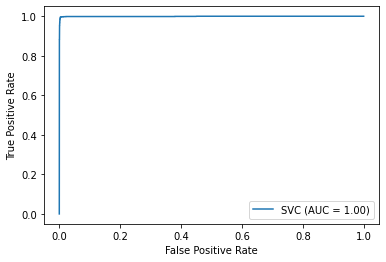

In [74]:
metrics.plot_roc_curve(clf_tf, X_train, Y_train)


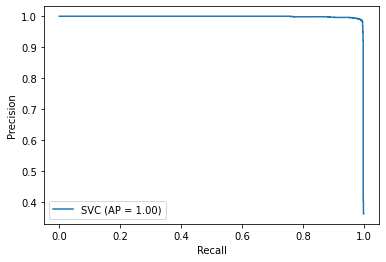

In [77]:
metrics.plot_precision_recall_curve(clf_tf, X_train, Y_train)


##**Roc and precison recall curve for Tfidf test data.**


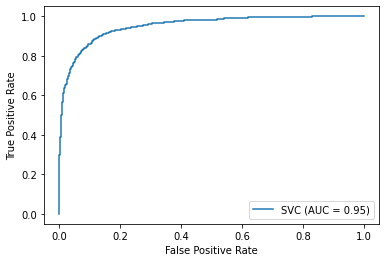

In [78]:
metrics.plot_roc_curve(clf_tf, X_test, Y_test)


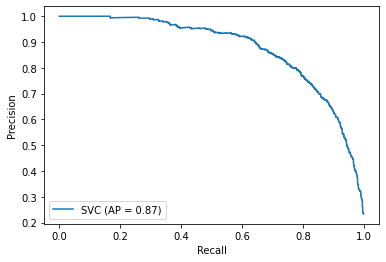

In [79]:
metrics.plot_precision_recall_curve(clf_tf, X_test, Y_test)


# Applying Grid CV 

In [80]:
# defining parameter range
param_dict = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear','poly']} 
grid_tf= GridSearchCV(clf_tf, param_dict,n_jobs=2, cv=5, verbose = 2,scoring='accuracy')

In [81]:
grid_tf.fit(X_train,Y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed: 10.8min
[Parallel(n_jobs=2)]: Done 375 out of 375 | elapsed: 11.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=2)

In [83]:
# Best values for C and Gamma are:
grid_tf.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

In [84]:
gridtf_train_pred=grid_tf.predict(X_train)

In [85]:
gridtf_test_pred=grid_tf.predict(X_test)

In [86]:
# Confusion matrices for train and test 

print(confusion_matrix(Y_train,gridtf_train_pred))
print(confusion_matrix(Y_test,gridtf_test_pred))

[[5491   18]
 [  66 1349]]
[[3564  105]
 [ 275  673]]


In [87]:
# Print the classification report for train and test
print(classification_report(Y_train,gridtf_train_pred))
print("\n")
print(classification_report(Y_test,gridtf_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5509
           1       0.99      0.95      0.97      1415

    accuracy                           0.99      6924
   macro avg       0.99      0.98      0.98      6924
weighted avg       0.99      0.99      0.99      6924



              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3669
           1       0.87      0.71      0.78       948

    accuracy                           0.92      4617
   macro avg       0.90      0.84      0.86      4617
weighted avg       0.92      0.92      0.91      4617



**As we can see from above all models perform well on train as well as test dataset.**